In [241]:
import pandas as pd
import numpy as np
import operator
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [227]:
df = pd.read_csv("time_series_covid_19_confirmed.csv", sep=",")
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,969,981,989,998,1004,1029,1050,1076,1099,1122
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,762,762,762,762,763,763,763,763,764,764
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,58,60,61,69,70,70,71,74,81,84


In [228]:

coun=df.set_index('Country/Region').iloc[:,3:-3]
countries=coun.index.drop_duplicates()
coun=coun.T
pak_data=coun['Pakistan']
correlation={}
for country in countries:
    dfr1=coun[country]
    if isinstance(dfr1,pd.core.series.Series):
            x_ax=dfr1
        
    else:
            x_ax=dfr1.sum(axis=1)
    
    corr=np.corrcoef(pak_data,x_ax )
    correlation[country]=corr[0][1]

sort_corr = sorted(correlation.items(), key=operator.itemgetter(1),reverse=True)
selected_countries=['Pakistan']
for i in range(5):
    print(sort_corr[i+1][0],sort_corr[i+1][1])
    selected_countries.append(sort_corr[i+1][0])


Saudi Arabia 0.9989666872972038
Qatar 0.9987397834693383
Colombia 0.9987031556505498
Peru 0.9986075757030275
Egypt 0.9985861314636708


In [336]:
def prepare_data(country,window,string='none'):
    train=[]
    label=[]
    data=[]
    country_data=coun[country]
    prev_cases=0
    for dta in country_data:
        if (dta > 0):
            if string=='rnn':
                data.append([dta-prev_cases])
            else:
                data.append(dta-prev_cases)
            prev_cases=dta
    if (string == 'rnn'):
        scaler = MinMaxScaler()
        scaler.fit(data)
        data = scaler.transform(data)
  
    for i in range(len(data)-window-1):
        x = data[i:(i+window)]
        y = data[i+window]
        train.append(x)
        label.append(y)
    if string=='rnn':
        return torch.tensor(train), torch.tensor(label), scaler
    return train,label

In [230]:
def accuracy(y_true,y_pred):
    mse=mean_squared_error(y_true, y_pred)
    return math.sqrt(mse)

In [304]:
last_day = -17
window = 5
days=[]
day = 11
for i in range(17):
    days.append(day+i)

In [345]:
country_pred={}
month_pred={}
for country in selected_countries:
    clf = MLPClassifier(hidden_layer_sizes=(100,100,100),max_iter=1000)
    train,label=prepare_data(country,5)
    trainx = train[:-17]
    labelx = label[:-17]
    clf.fit(trainx,labelx)
    xtest = train[-17:]
    ytest = label[-17:]
    predicted=clf.predict(xtest)
    country_pred[country] = predicted
    print(country,accurac)

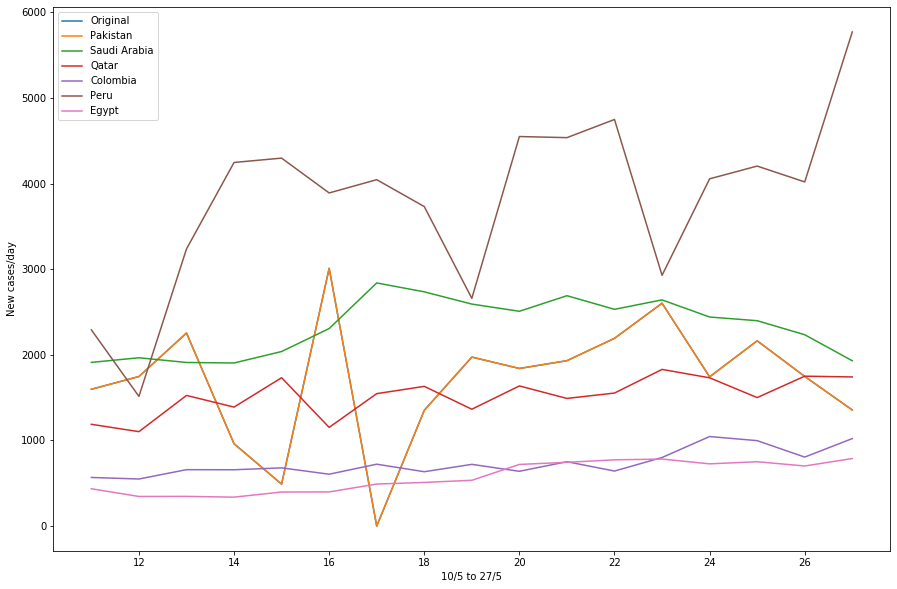

In [307]:
__, pak_label=prepare_data('Pakistan',5)
pak_label = pak_label[-17:]
plt.rcParams['figure.figsize']=(15,10)
plt.plot(days,pak_label)
legend=['Original']
for data in country_pred:
    plt.plot(days,country_pred[data])
    legend.append(data)
plt.legend(legend)
plt.xlabel('10/5 to 27/5')
plt.ylabel('New cases/day')
plt.show()

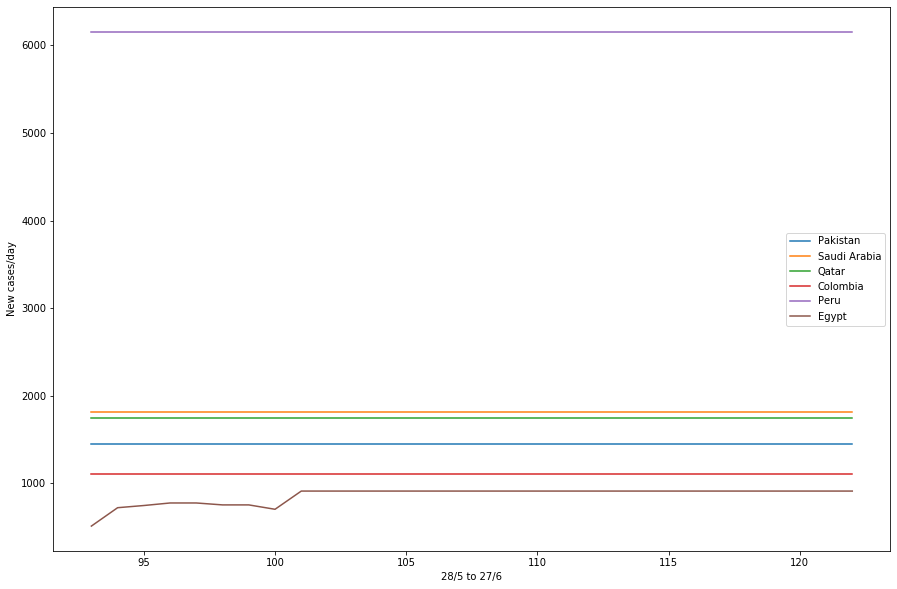

In [234]:
plt.rcParams['figure.figsize']=(15,10)
legend=[]
for data in month_pred:
    plt.plot(pred_days,month_pred[data])
    legend.append(data)
plt.legend(legend)
plt.xlabel('28/5 to 27/6')
plt.ylabel('New cases/day')
plt.show()

In [255]:
class RNN(nn.Module):
    def __init__(self, n_layers, n_inputs, n_neurons, n_outputs, seq_length):
        super(RNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.seq_len = seq_length
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons, self.n_layers) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
         
        self.hidden = torch.zeros(self.n_layers, self.seq_len, self.n_neurons)
        
        
    def forward(self, X):
    
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(lstm_out.view(self.seq_len, len(X), self.n_neurons)[-1])
        return out

In [237]:
SEQ_LENGTH = 5
N_STEPS = 3
N_INPUTS = 1
N_NEURONS = 100
N_OUTPUTS = 1

In [340]:
country_predrnn={}
scaler = MinMaxScaler()
for country in selected_countries:
    model = RNN(N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS, SEQ_LENGTH)
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    trainX,trainy,scaler=prepare_data(country ,5, 'rnn')
    
    for epoch in range(1000): 
        model.train()
        model.hidden = model.init_hidden()
        output = model(trainX.float())
        loss = criterion(output.float(), trainy.float())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    xtest = trainX[-17:]
    ytest = trainy[-17:]
    output1 = model(xtest.float())
    print(country)
    output1 = np.rint(scaler.inverse_transform(output1.detach().numpy()))
    ytest = scaler.inverse_transform(ytest.detach().numpy())
    country_predrnn[country] = output1
    print(accuracy(output1,ytest))

Pakistan
1306.6415413750854
Saudi Arabia
1423.0225081928709
Qatar
989.9890076632759
Colombia
222.13045981240526
Peru
2364.2057241032035
Egypt
191.16515803633993


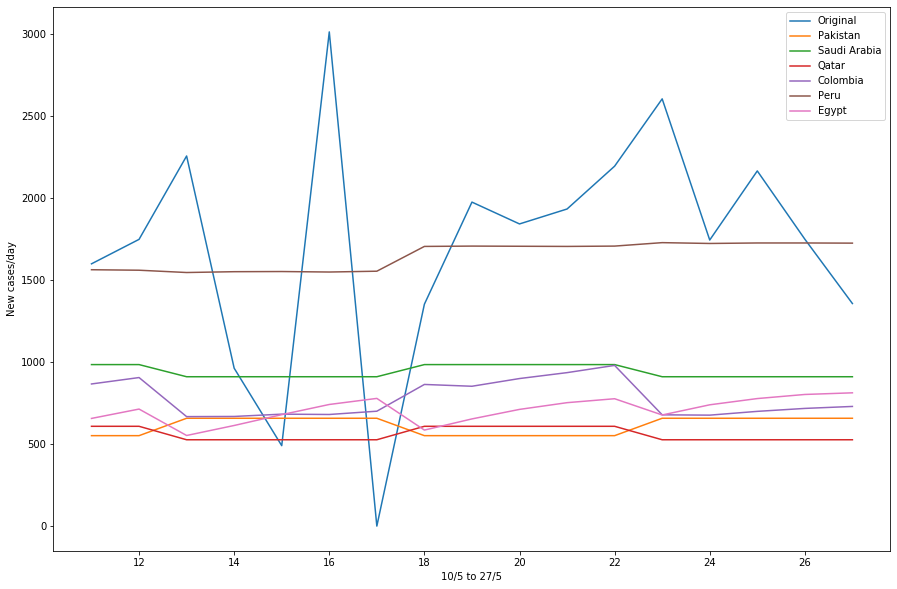

In [343]:
plt.rcParams['figure.figsize']=(15,10)
plt.plot(days,pak_label)
legend=['Original']
for data in country_pred:
    plt.plot(days,country_predrnn[data])
    legend.append(data)
plt.legend(legend)
plt.xlabel('10/5 to 27/5')
plt.ylabel('New cases/day')
plt.show()

In [342]:
print(country_predrnn)

{'Pakistan': array([[551.],
       [551.],
       [657.],
       [657.],
       [657.],
       [657.],
       [657.],
       [551.],
       [551.],
       [551.],
       [551.],
       [551.],
       [657.],
       [657.],
       [657.],
       [657.],
       [657.]], dtype=float32), 'Saudi Arabia': array([[984.],
       [984.],
       [910.],
       [910.],
       [910.],
       [910.],
       [910.],
       [984.],
       [984.],
       [984.],
       [984.],
       [984.],
       [910.],
       [910.],
       [910.],
       [910.],
       [910.]], dtype=float32), 'Qatar': array([[608.],
       [608.],
       [526.],
       [526.],
       [526.],
       [526.],
       [526.],
       [608.],
       [608.],
       [608.],
       [608.],
       [608.],
       [526.],
       [526.],
       [526.],
       [526.],
       [526.]], dtype=float32), 'Colombia': array([[866.],
       [905.],
       [667.],
       [668.],
       [682.],
       [680.],
       [700.],
       [863.],
       [852.],